In [89]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from geopy.distance import geodesic
import folium
import string
import seaborn as sns
from scipy import stats, integrate
import math

# Data Cleaning

In [514]:
imu_data = pd.read_csv('data_csv/imudata_circles.csv')
imu_driving_data = pd.read_csv('data_csv/imudata_driving.csv')

In [523]:
df = imu_data
df_driving = imu_driving_data
#drop the empty unnamed columns
df_driving = df_driving.loc[:, ~df_driving.columns.str.contains('^Unnamed')]
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

In [524]:
df = df.drop(columns=df.columns[(df == 0).all(axis=0)])
df_driving = df_driving.drop(columns=df_driving.columns[(df_driving == 0).all(axis=0)])

In [525]:
df.columns = ['secs', 'nsecs', 'frame_id', 'orientation_x', 'orientation_y', 'orientation_z', 'orientation_w', 'angular_velocity_x', 'angular_velocity_y', 'angular_velocity_z', 'linear_acceleration_x', 'linear_acceleration_y', 'linear_acceleration_z', 'mag_x', 'mag_y', 'mag_z']
df_driving.columns = ['secs', 'nsecs', 'frame_id', 'orientation_x', 'orientation_y', 'orientation_z', 'orientation_w', 'angular_velocity_x', 'angular_velocity_y', 'angular_velocity_z', 'linear_acceleration_x', 'linear_acceleration_y', 'linear_acceleration_z', 'mag_x', 'mag_y', 'mag_z']

In [526]:
df['time'] = (df['secs'] - df['secs'].min()) + (df['nsecs'] * 1e-9)
df_driving['time'] = (df_driving['secs'] - df_driving['secs'].min()) + (df_driving['nsecs'] * 1e-9)

In [527]:
df['mag_x'] = df['mag_x'] * 1e-8
df['mag_y'] = df['mag_y'] * 1e-8
df['mag_z'] = df['mag_z'] * 1e-8

df_driving['mag_x'] = df_driving['mag_x'] * 1e-8
df_driving['mag_y'] = df_driving['mag_y'] * 1e-8
df_driving['mag_z'] = df_driving['mag_z'] * 1e-8

In [480]:
df_driving.to_csv('data_csv/drivingclean.csv', index=False)


In [481]:
gps_driving_path = 'data_csv/gpsdata_driving.csv'
gps_circles_path = 'data_csv/gpsdata_circles.csv'

In [482]:
def read_df(path):
    df = pd.read_csv(path, header=None)
    df.columns = ['secs', 'nsecs', 'Frame_ID', 'latitude', 'longitude', 'altitude', 'utm_easting', 'utm_northing', 'zone', 'letter']
    return df

gps_driving = read_df(gps_driving_path)
gps_circles = read_df(gps_circles_path)


# Magnetometer Calibration

## Data Before Calibration

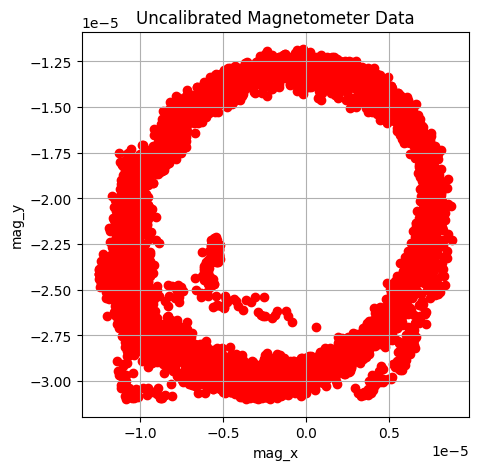

In [483]:
mag = df[(df['mag_x'] > -1.25e-5) & (df['mag_y'] > -3.1e-5)]
plt.figure(figsize=(5, 5))
plt.scatter(mag['mag_x'], mag['mag_y'], color='red')
plt.xlabel('mag_x')
plt.ylabel('mag_y')
plt.grid()
plt.title('Uncalibrated Magnetometer Data')
plt.show()

Center (x, y): (-1.4503873930911063e-06, -2.1466966826789947e-05)
Semi-major axis length: 9.25086990527564e-06
Semi-minor axis length: 7.957083468901201e-06
Rotation angle (radians): 0.5956300451058584


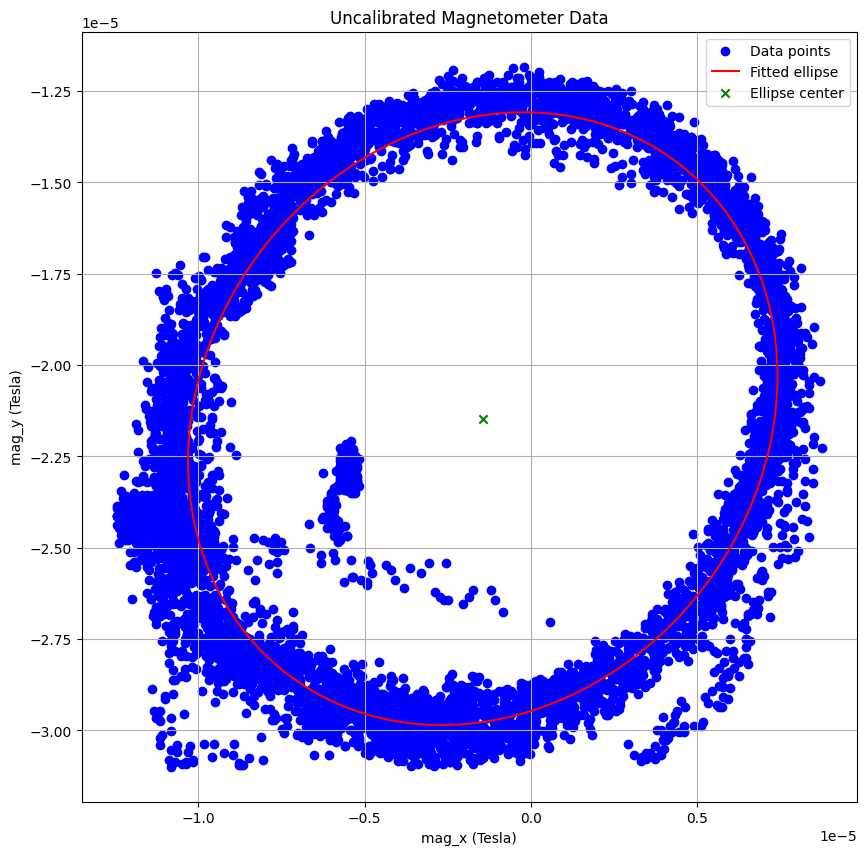

In [484]:
from skimage.measure import EllipseModel

points = np.array(list(zip(mag['mag_x'], mag['mag_y'])))
model = EllipseModel()
model.estimate(points)

#get parameters of the ellipse
xc, yc, a, b, theta = model.params
print("Center (x, y):", (xc, yc))
print("Semi-major axis length:", a)
print("Semi-minor axis length:", b)
print("Rotation angle (radians):", theta)

# generate some ellipse points
t = np.linspace(0, 2 * np.pi, 200)
ellipse_x = xc + a * np.cos(t) * np.cos(theta) - b * np.sin(t) * np.sin(theta)
ellipse_y = yc + a * np.cos(t) * np.sin(theta) + b * np.sin(t) * np.cos(theta)

# Plot the original points and the fitted ellipse
plt.figure(figsize=(10, 10))
plt.scatter(mag['mag_x'], mag['mag_y'], color='blue', label="Data points")
plt.plot(ellipse_x, ellipse_y, color='red', label="Fitted ellipse")
plt.scatter(xc, yc, color='green', marker='x', label="Ellipse center")

plt.xlabel('mag_x (Tesla)')
plt.ylabel('mag_y (Tesla)')
plt.grid()
plt.legend()
plt.title('Uncalibrated Magnetometer Data')
plt.show()



## Hard Iron Calibration

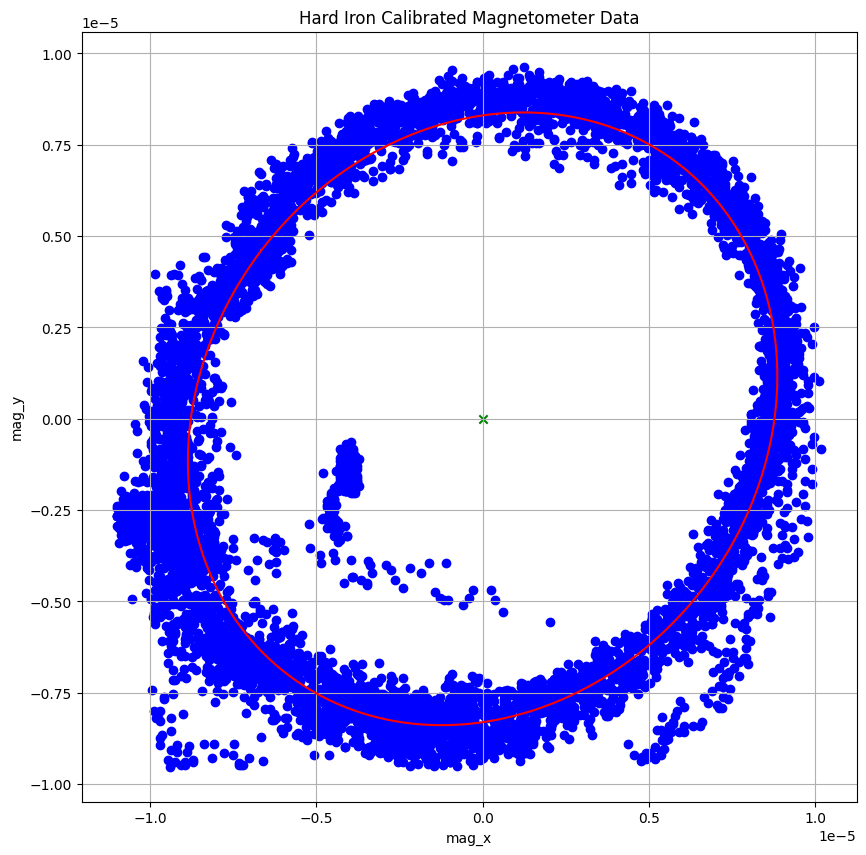

In [485]:
# Fix the Hard Iron biased based on the ellipsoide data
HI_magx = mag['mag_x'] - xc
HI_magy = mag['mag_y'] - yc


# generate some ellipse points
t = np.linspace(0, 2 * np.pi, 200)

HI_ellipse_x = xc + a * np.cos(t) * np.cos(theta) - b * np.sin(t) * np.sin(theta) -xc
HI_ellipse_y = yc + a * np.cos(t) * np.sin(theta) + b * np.sin(t) * np.cos(theta) -yc

#plot the data after fixing the hard iron bias with the fitted ellipse
plt.figure(figsize=(10, 10))
plt.scatter(HI_magx, HI_magy, color='blue', label="Data points")
plt.plot(HI_ellipse_x, HI_ellipse_y, color='red', label="Fitted ellipse")
plt.scatter(0, 0, color='green', marker='x', label="Ellipse center")
plt.xlabel('mag_x')
plt.ylabel('mag_y')
plt.grid()
plt.title('Hard Iron Calibrated Magnetometer Data')
plt.show()

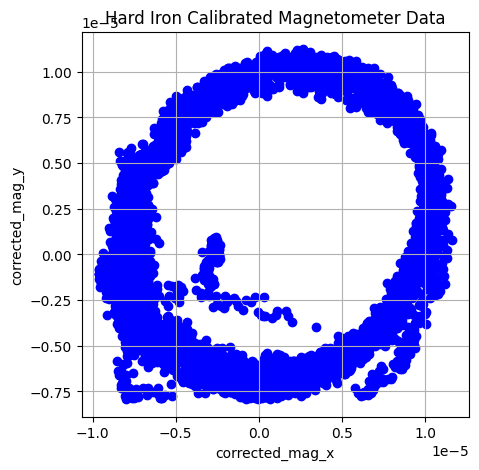

In [486]:

magx_mean = mag['mag_x'].mean()
magy_mean = mag['mag_y'].mean()

corrected_magx = mag['mag_x'] - magx_mean
corrected_magy = mag['mag_y'] - magy_mean

plt.figure(figsize=(5, 5))
plt.scatter(corrected_magx, corrected_magy, color = 'blue')
plt.grid()
plt.xlabel('corrected_mag_x')
plt.ylabel('corrected_mag_y')
plt.title('Hard Iron Calibrated Magnetometer Data')
plt.show()



## Soft Iron Correction

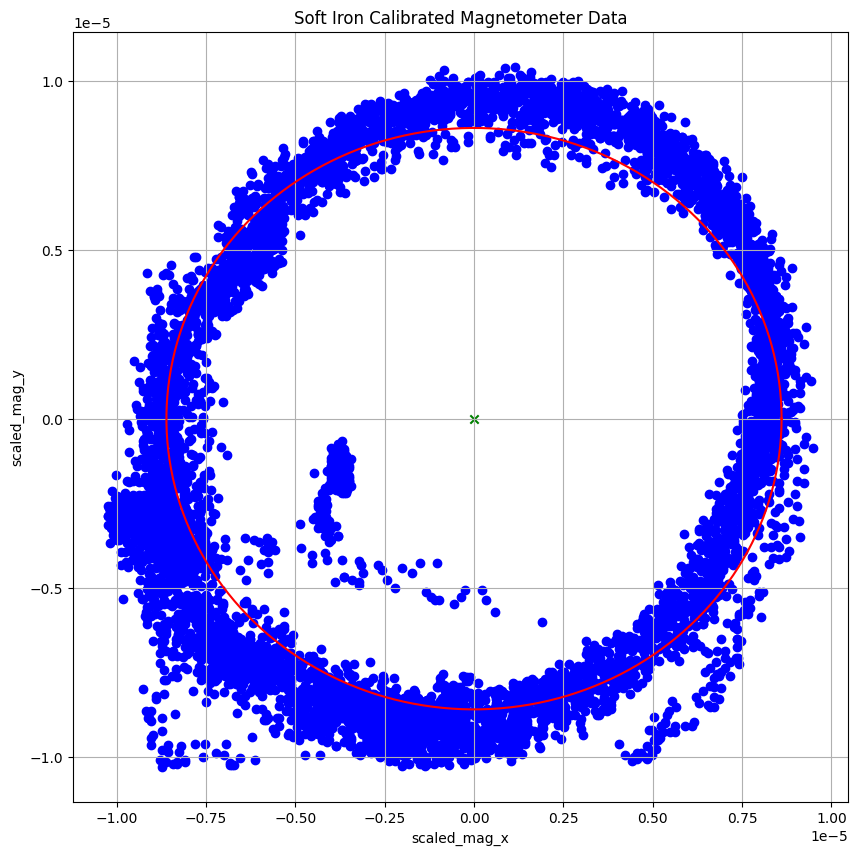

In [487]:
# fix the soft iron bias by scaling the data from the ellipse
# scale the data
average_radius = (a + b) / 2
scale_x = average_radius / a
scale_y = average_radius / b

circle_x = average_radius * np.cos(t)
circle_y = average_radius * np.sin(t)

scaled_magx = HI_magx * scale_x
scaled_magy = HI_magy * scale_y

plt.figure(figsize=(10, 10))
plt.scatter(scaled_magx, scaled_magy, color = 'blue')
plt.plot(circle_x, circle_y, color='red')
plt.scatter(0, 0, color='green', marker='x')
plt.grid()
plt.xlabel('scaled_mag_x')
plt.ylabel('scaled_mag_y')
plt.title('Soft Iron Calibrated Magnetometer Data')
plt.show()

In [ ]:
#plot the driving data before magnetometer calibration

5.984904476642162e-06
-0.42758760296096077


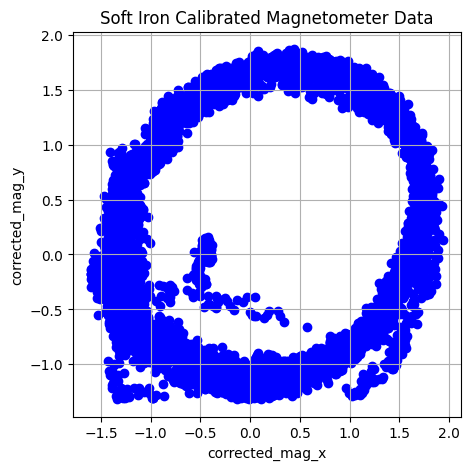

In [488]:
from sklearn.preprocessing import StandardScaler
# soft iron correction
# scale the data
magx_std = df["mag_x"].std()
magy_std = df["mag_y"].std()
print(magx_std)

soft_magx = corrected_magx / magx_std
soft_magy = corrected_magy / magy_std

# scalar = StandardScaler()
# soft_magx = scalar.fit_transform(df[['mag_x']])
# soft_magy = scalar.fit_transform(df[['mag_y']])
print(soft_magx[87])

plt.figure(figsize=(5, 5))
plt.scatter(soft_magx, soft_magy, color = 'blue')
plt.grid()
plt.xlabel('corrected_mag_x')
plt.ylabel('corrected_mag_y')
plt.title('Soft Iron Calibrated Magnetometer Data')
plt.show()

# Yaw Analysis

## Yaw from Magnetometer

In [489]:
def wrap_to_pi(data):
    data_wrapped_to_pi = data% 360
    mask = np.abs(data_wrapped_to_pi)>180
    data_wrapped_to_pi[mask] -= 360*np.sign(data_wrapped_to_pi[mask])
    return data_wrapped_to_pi

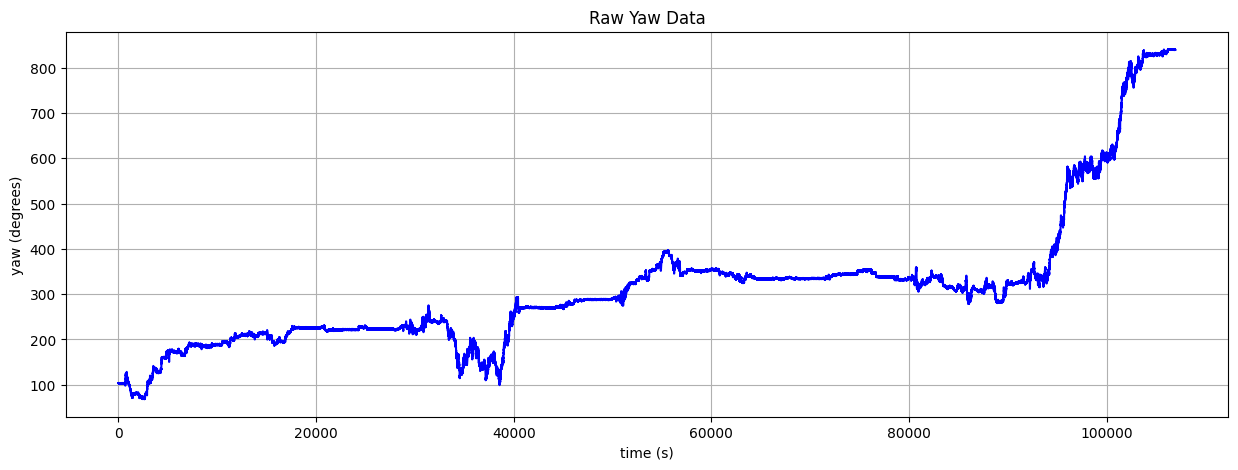

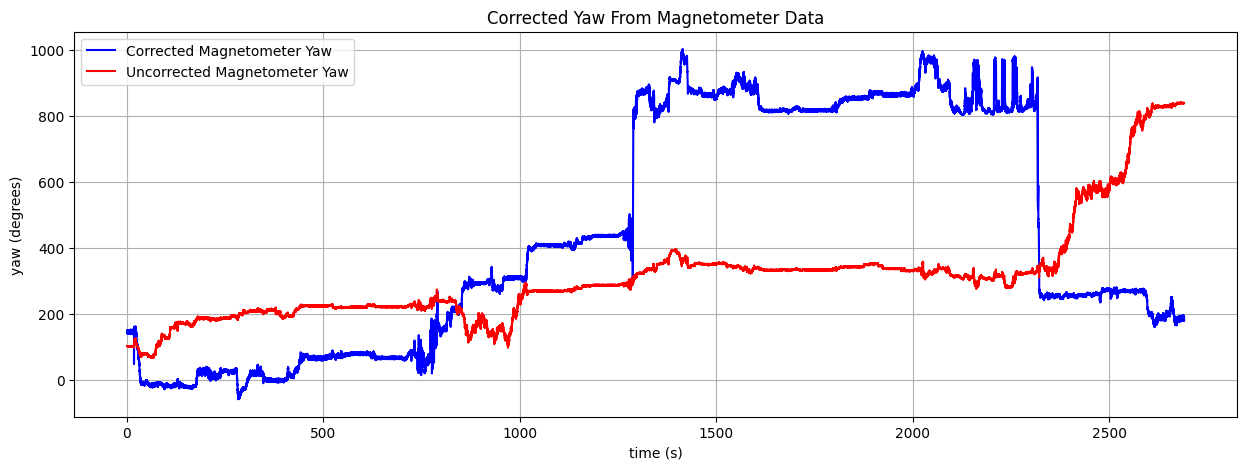

In [957]:
HI_magx_driving = df_driving['mag_x'] - xc
HI_magy_driving = df_driving['mag_y'] - yc
corr_magx_dr = HI_magx_driving * scale_x
corr_magy_dr = HI_magy_driving * scale_y

#uncorrected yaw plotted
uncorrected_yaw = -np.degrees(np.arctan2(df_driving['mag_y'], df_driving['mag_x']))
uncorrected_yaw = np.unwrap(uncorrected_yaw)
# uncorrected_yaw += 180
plt.figure(figsize=(15, 5))
plt.plot(uncorrected_yaw, color='blue')
plt.grid()
plt.xlabel('time (s)')
plt.ylabel('yaw (degrees)')
plt.title('Raw Yaw Data')
plt.show()

#corrected yaw plotted
# yaw = np.degrees(np.arctan2(corr_magx_dr, corr_magy_dr))
yaw = -np.arctan2(corr_magy_dr, corr_magx_dr)
yaw = np.unwrap(yaw)
yaw = np.degrees(yaw)

#plot the yaw
plt.figure(figsize=(15, 5))
plt.plot(df_driving['time'], yaw, color='blue')
plt.plot(df_driving['time'], uncorrected_yaw, color='red')
plt.legend(['Corrected Magnetometer Yaw', 'Uncorrected Magnetometer Yaw'])
plt.grid()
plt.xlabel('time (s)')
plt.ylabel('yaw (degrees)')
plt.title('Corrected Yaw From Magnetometer Data')
plt.show()


In [633]:
def euler_from_quaternion(x, y, z, w):
        t0 = +2.0 * (w * x + y * z)
        t1 = +1.0 - 2.0 * (x * x + y * y)
        roll_x = math.atan2(t0, t1)
     
        t2 = +2.0 * (w * y - z * x)
        t2 = +1.0 if t2 > +1.0 else t2
        t2 = -1.0 if t2 < -1.0 else t2
        pitch_y = math.asin(t2)
     
        t3 = +2.0 * (w * z + x * y)
        t4 = +1.0 - 2.0 * (y * y + z * z)
        yaw_z = math.atan2(t3, t4)
     
        return roll_x, pitch_y, yaw_z # in radians

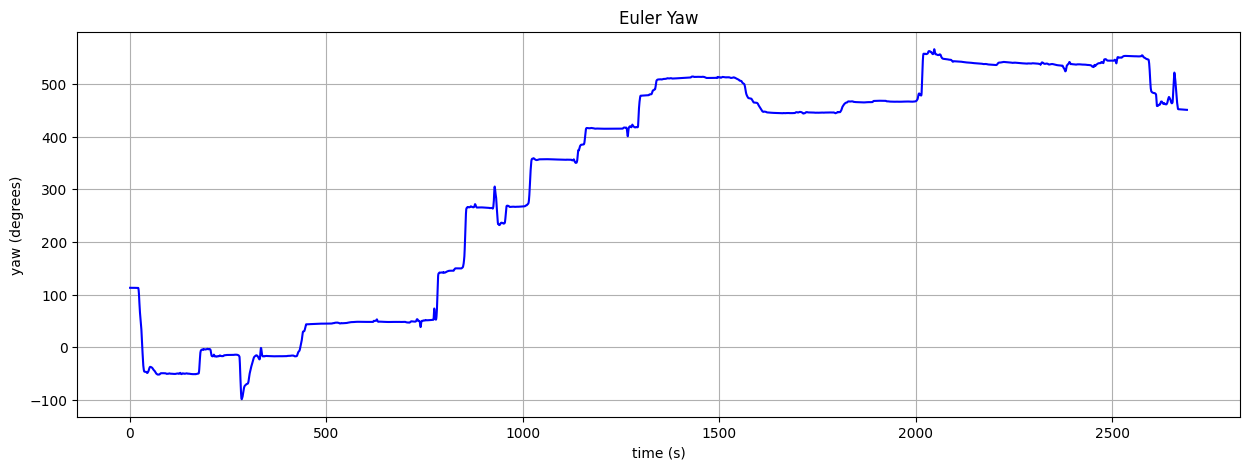

In [892]:
from scipy.ndimage import uniform_filter1d
#calculate the euler angles
df_driving['roll'], df_driving['pitch'], df_driving['yaw'] = zip(*df_driving.apply(lambda x: euler_from_quaternion(x['orientation_x'], x['orientation_y'], x['orientation_z'], x['orientation_w']), axis=1))
plt.figure(figsize=(15, 5))
euler_yaw = np.unwrap(df_driving['yaw'])
euler_yaw_deg = np.degrees(euler_yaw)
# window_size = 10  # Adjust as needed for smoothing level
# yaw_data_smoothed = uniform_filter1d(euler_yaw_deg, size=window_size)
# euler_yaw_wrap = (euler_yaw_deg + 180) % 360 - 180
plt.plot(df_driving['time'],euler_yaw_deg, color='blue')
plt.grid()
plt.xlabel('time (s)')
plt.ylabel('yaw (degrees)')
plt.title('Euler Yaw')
plt.show()


In [648]:
#calculate yaw from the angular velocity z using cumsum and wrap it to from -180 to 180
# yaw_gyro = (df_driving['angular_velocity_z'].cumsum() * df_driving['time'].diff().mean())
#integrate the angular velocity z to get the yaw
yaw_gyro = integrate.cumtrapz(df_driving['angular_velocity_z'], df_driving['time'], initial=0)
yaw_gyro = np.degrees(yaw_gyro)
# yaw_gyro = (yaw_gyro + 180) % 360 - 180


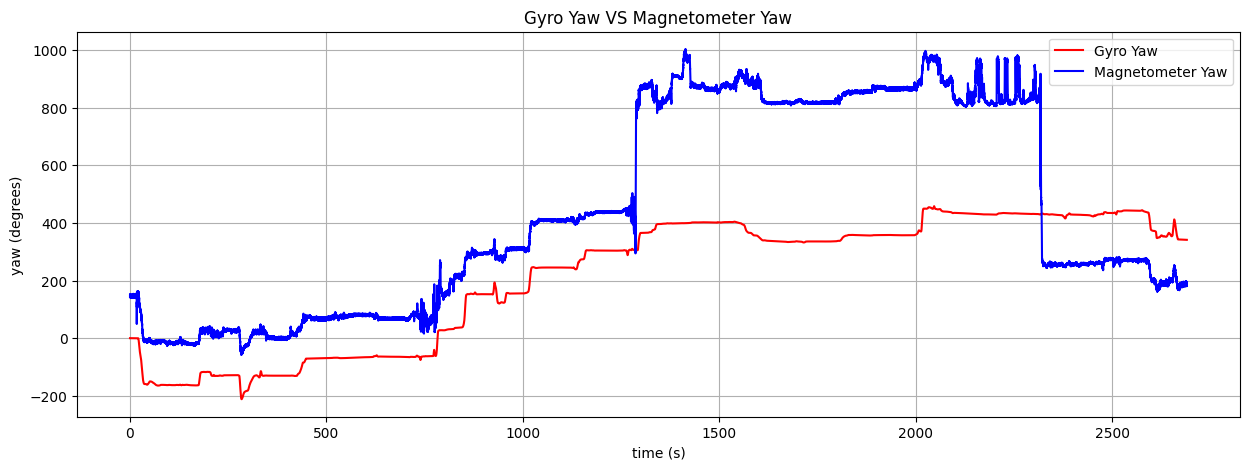

In [958]:
plt.figure(figsize=(15, 5))
plt.plot(df_driving['time'],yaw_gyro, label = 'Gyro Yaw', color='red')
plt.plot(df_driving['time'], yaw, label = 'Magnetometer Yaw', color='blue')
plt.legend()
plt.grid()
plt.xlabel('time (s)')
plt.ylabel('yaw (degrees)')
plt.title('Gyro Yaw VS Magnetometer Yaw')
plt.show()

# Complimentary Filter

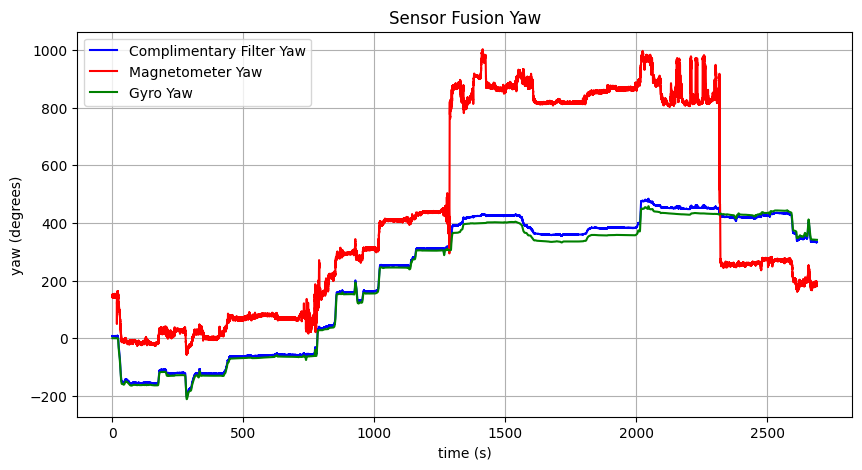

In [959]:
alpha = 0.95

lpf = (1 - alpha) * (yaw)
hpf = alpha * yaw_gyro 

# complimentary_filter = high_pass_filter(yaw_gyro, alpha)
# complimentary_filter = complementary_filter(yaw, yaw_gyro, df_driving['time'], alpha=alpha)
filtered_yaw = hpf+lpf
plt.figure(figsize=(10,5))
plt.plot(df_driving['time'], filtered_yaw, label='Complimentary Filter Yaw', color='blue')
plt.plot(df_driving['time'], yaw, label='Magnetometer Yaw', color='red')
plt.plot(df_driving['time'], yaw_gyro, label='Gyro Yaw', color='green')
plt.grid()
plt.xlabel('time (s)')
plt.ylabel('yaw (degrees)')
plt.title('Sensor Fusion Yaw')
plt.legend()
plt.show()

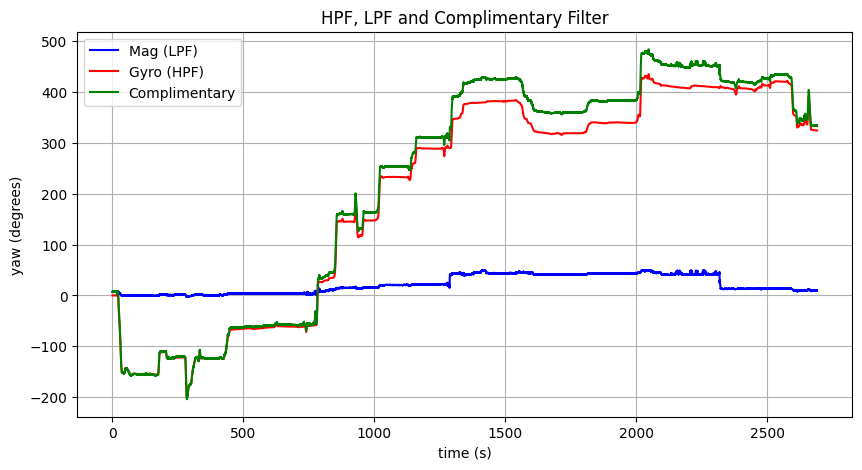

In [960]:
# alpha = 0.96
# complimentary_filter = high_pass_filter(yaw_gyro, alpha)
# complimentary_filter = complementary_filter(yaw, yaw_gyro, df_driving['time'], alpha=alpha)

# complementary_filter = lpf + hpf
plt.figure(figsize=(10,5))
plt.plot(df_driving['time'], lpf, label='Mag (LPF)', color='blue')
plt.plot(df_driving['time'], hpf, label='Gyro (HPF)', color='red')
plt.plot(df_driving['time'], filtered_yaw, label='Complimentary', color='green')
plt.grid()
plt.xlabel('time (s)')
plt.ylabel('yaw (degrees)')
plt.title('HPF, LPF and Complimentary Filter')
plt.legend()
plt.show()

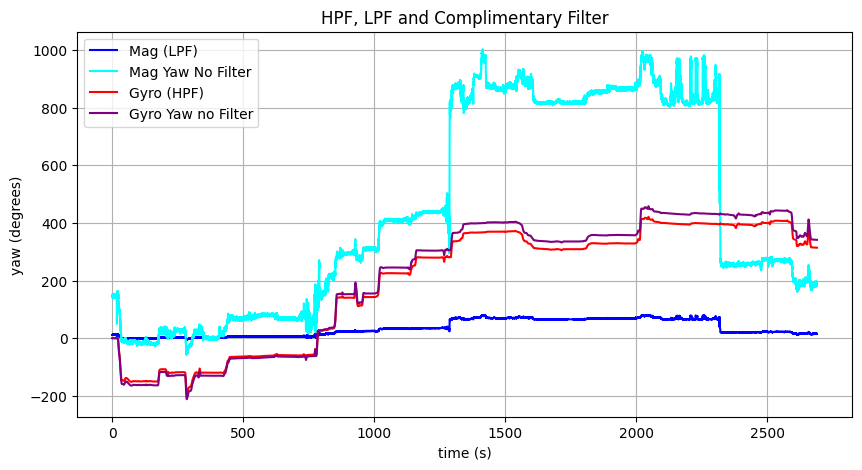

In [920]:
plt.figure(figsize=(10,5))
plt.plot(df_driving['time'], lpf, label='Mag (LPF)', color='blue')
plt.plot(df_driving['time'], yaw, label='Mag Yaw No Filter', color='cyan')
plt.plot(df_driving['time'], hpf, label='Gyro (HPF)', color='red')
plt.plot(df_driving['time'], yaw_gyro, label='Gyro Yaw no Filter', color = 'purple')
plt.grid()
plt.xlabel('time (s)')
plt.ylabel('yaw (degrees)')
plt.title('HPF, LPF and Complimentary Filter')
plt.legend()
plt.show()

## Sensor Fusion vs Calculated

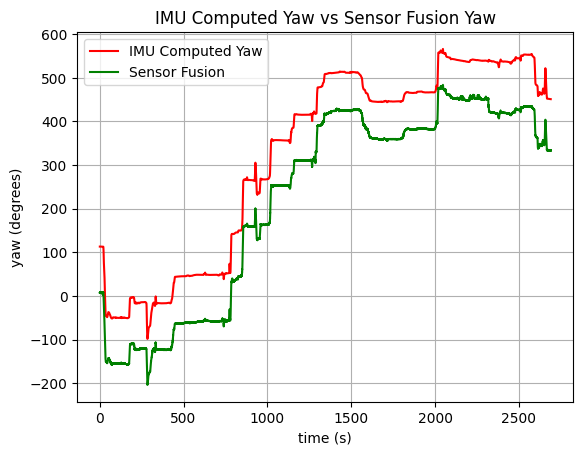

In [963]:
eu_yaw = (euler_yaw + np.pi) % (2 * np.pi) - np.pi
comp_fil = (np.deg2rad(filtered_yaw) + np.pi) % (2 * np.pi) - np.pi
comp_fil = filtered_yaw
euler_yaw_dega = (euler_yaw_deg % 360)#-180
# complementary_filtera = (complementary_filter % 360)+180
compl_filter = comp_fil #+(euler_yaw_deg[0]-comp_fil[0])
# compl_filter = compl_filter % 360
# compl_filter = np.arctan2(np.sin(np.radians(compl_filter)), np.cos(np.radians(compl_filter))) * 180 / np.pi
plt.plot(df_driving['time'], euler_yaw_deg, label='IMU Computed Yaw', color='red')
plt.plot(df_driving['time'], compl_filter, label='Sensor Fusion', color='green')
plt.grid()
plt.xlabel('time (s)')
plt.ylabel('yaw (degrees)')
plt.title('IMU Computed Yaw vs Sensor Fusion Yaw')
plt.legend()
plt.show()

# Dead Reckoning


Velocity Statistics:
GPS Velocity - Mean: 1.58 m/s, Max: 11.59 m/s
Integrated Velocity (Before) - Mean: 1.21 m/s, Max: 10.82 m/s

Percentage of time stopped: 54.3%
Number of distinct stops: 1416


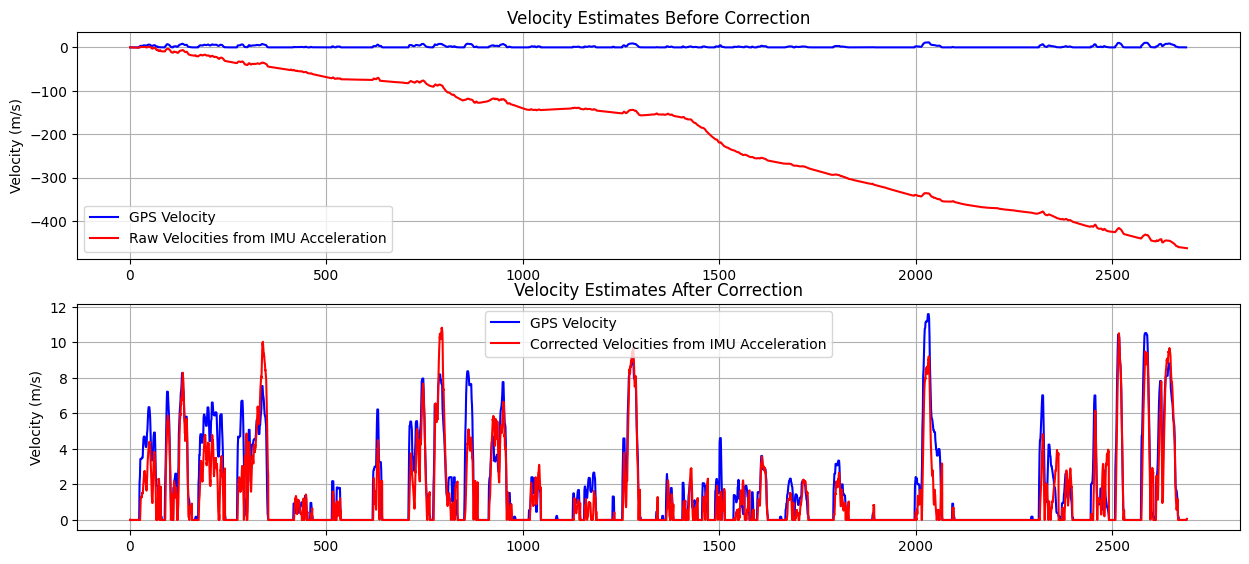

In [1043]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import cumtrapz
from scipy.signal import medfilt, savgol_filter
from scipy.interpolate import interp1d

def calculate_gps_velocity(df_gps):
    # Calculate distance between consecutive points using UTM coordinates
    delta_easting = np.diff(df_gps['utm_easting'])
    delta_northing = np.diff(df_gps['utm_northing'])
    
    # Calculate total distance moved
    distances = np.sqrt(delta_easting**2 + delta_northing**2)
    # Calculate time differences in seconds
    times = (df_gps['secs'] - min(df_gps['secs'])) + df_gps['nsecs'] * 1e-9
    delta_times = np.diff(times)
    # Calculate velocities (m/s)
    velocities = distances / delta_times
    # Apply median filter to remove GPS noise
    velocities_filtered = medfilt(velocities, kernel_size=5)
    # Add a timestamp for plotting (use midpoint of time intervals)
    timestamps = times[:-1] + delta_times/2
    
    return timestamps, velocities_filtered

def detect_stops(velocity, gps_df, threshold=0.1):
    # return velocities < threshold
    times_stopped = []
    for i in range(len(velocity)):
        if velocity[i] < np.abs(threshold):
            times_stopped.append(gps_df['secs'][i])
    return times_stopped

times = (df_driving['secs'] - min(df_driving['secs'])) + df_driving['nsecs'] * 1e-9
def integrate_acceleration_with_stops(df_driving, times_stopped):
    accel = df_driving['linear_acceleration_x']
    
    #put zeros at time stamps where the vehicle is stopped based on the stopped time stamps
    sum = 0
    stopped = 0
    bias = 0
    #=====old code for bias correction================#
    # # Integrate corrected acceleration
    # accel = accel * 0.85
    raw_velocity = cumtrapz(accel, times, initial=0)

    # velocity_drift = raw_velocity[-1] - raw_velocity[0]  # Total drift in velocity
    # print("Drift {}".format(velocity_drift))
    # print("Time {}".format(df_driving['time'].iloc[-1] ))

    # estimated_bias = velocity_drift / df_driving['time'].iloc[-1]    # Bias that would cause this drift
    # corrected_accel = accel #- estimated_bias
    corrected_accel = adjust_acceleration(accel)
    velocity = cumtrapz(corrected_accel, times, initial=0)
    # velocity = velocity - velocity[0]
    #stops = detect_stops(velocity, df_driving, threshold=0.1) # this is working and produces very similar results to the stops from the GPS data
    # print(stops)                                            # only disabled because it takes so long to load
    for i in range(len(velocity)):
        if df_driving['secs'][i] in times_stopped:
            velocity[i:] -= velocity[i]
        if velocity[i] < 0:
            velocity[i] = velocity[i] * -1
    
    return times, velocity, raw_velocity, corrected_accel

# def adjust_acceleration(accel, window_size = 4000):
#     """Apply corrections to acceleration data"""
#     # Use moving window to estimate and remove local bias
#     # window_size = 3500
#     #for the first 300 values, the bias is the mean of the first 300 values

#     bias = np.convolve(accel, np.ones(window_size)/window_size, mode='same')
#     return accel - bias

def adjust_acceleration(accel, window_size=3500, skip_initial=10000):
    #Calculate bias for the initial values using their mean
    initial_bias = np.mean(accel[:skip_initial])
    #Apply the constant bias to the first `skip_initial` values
    corrected_accel = np.copy(accel)
    corrected_accel[:skip_initial] -= initial_bias
    # Calculate the bias for the rest using convolution and apply
    bias = np.convolve(accel[skip_initial:], np.ones(window_size) / window_size, mode='same')
    #Subtract the calculated bias from the remaining part of accel
    corrected_accel[skip_initial:] -= bias
    
    return corrected_accel

# Calculate GPS velocity
gps_times, gps_velocities = calculate_gps_velocity(gps_driving)

# Detect stops using GPS velocity
stops_timestamps = detect_stops(gps_velocities,gps_driving, threshold=0.3)

# Velocity integration
t,initial_velocity, raw_velocity, acceleration_corr = integrate_acceleration_with_stops(df_driving, stops_timestamps)

# Plotting
plt.figure(figsize=(15, 10))

# Plot 1: Before correction
plt.subplot(3, 1, 1)
plt.plot(gps_times, gps_velocities, 'b-', label='GPS Velocity')
plt.plot(t, raw_velocity, 'r-', label='Raw Velocities from IMU Acceleration')
plt.ylabel('Velocity (m/s)')
plt.title('Velocity Estimates Before Correction')
plt.legend()
plt.grid(True)

# Plot 2: After correction
plt.subplot(3, 1, 2)
plt.plot(gps_times, gps_velocities, 'b-', label='GPS Velocity')
plt.plot(t, initial_velocity, 'r-', label='Corrected Velocities from IMU Acceleration')
plt.ylabel('Velocity (m/s)')
plt.title('Velocity Estimates After Correction')
plt.legend()
plt.grid(True)

# Print statistics for comparison
print("\nVelocity Statistics:")
print(f"GPS Velocity - Mean: {np.mean(gps_velocities):.2f} m/s, Max: {np.max(gps_velocities):.2f} m/s")
print(f"Integrated Velocity (Before) - Mean: {np.mean(initial_velocity):.2f} m/s, Max: {np.max(initial_velocity):.2f} m/s")
# print(f"Integrated Velocity (After) - Mean: {np.mean(corrected_velocities):.2f} m/s, Max: {np.max(corrected_velocities):.2f} m/s")

# stop_indices = detect_stops(gps_velocities)
# Print stop statistics
stop_percentage = (len(stops_timestamps) / len(gps_velocities)) * 100
print(f"\nPercentage of time stopped: {stop_percentage:.1f}%")
print(f"Number of distinct stops: {np.sum(np.diff(stops_timestamps) == 1)}")

# 3. Displacement and Trajectory

[]

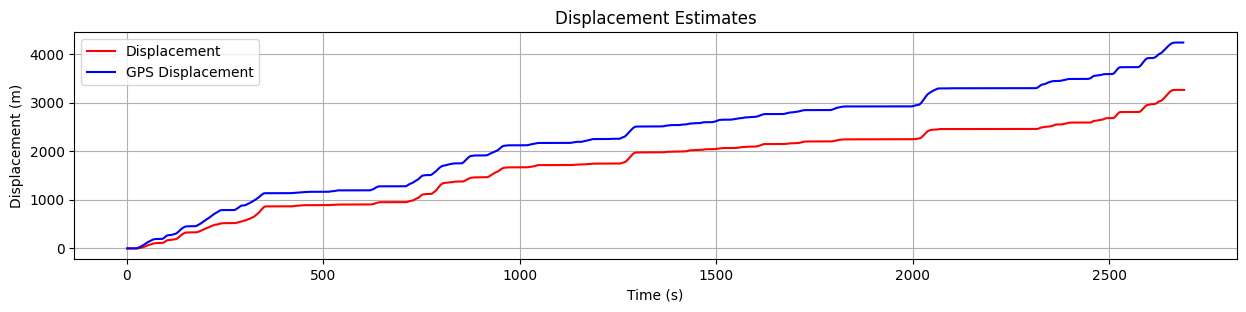

In [945]:

raw_displacement = cumtrapz(initial_velocity, t, initial=0)
GPS_displacement = cumtrapz(gps_velocities, gps_times, initial=0)
plt.figure(figsize=(15, 10))
plt.subplot(3, 1, 3)
plt.plot(t, raw_displacement, 'r-', label='Displacement')
plt.plot(gps_times, GPS_displacement, 'b-', label='GPS Displacement')
plt.xlabel('Time (s)')
plt.ylabel('Displacement (m)')
plt.title('Displacement Estimates')
plt.legend()
plt.grid(True)
plt.plot()

## 3.1

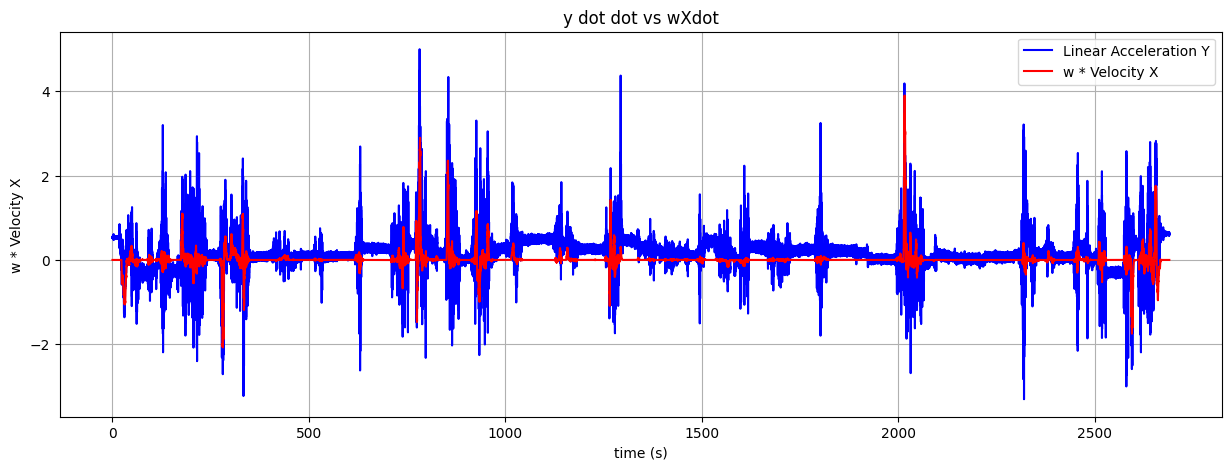

In [1073]:
w = df_driving['angular_velocity_z']
y_obs = df_driving['linear_acceleration_y']
#calculate w * Velcoity X
# x_dot = cumtrapz(acceleration_corr, df_driving['time'], initial=0)
X_dot = gps_velocities
X_dot_interp = interp1d(np.linspace(0, 1, len(X_dot)), X_dot, kind='linear')
X_dott = X_dot_interp(np.linspace(0, 1, len(w)))
wv_x = w * X_dott

#compare with the linear acceleration y
plt.figure(figsize=(15, 5))
# plt.plot(gps_times, wv_x, label='w * Velocity X', color='red')
# plt.plot(gps_times, w_, label='Linear Acceleration Y', color='blue')
plt.plot(t, y_obs, label='Linear Acceleration Y', color='blue')
plt.plot(t, wv_x, label='w * Velocity X', color='red')
plt.grid()
plt.xlabel('time (s)')
plt.ylabel('w * Velocity X')
plt.title('y dot dot vs wXdot')
plt.legend()
plt.show()

In [1052]:
# dt_moving = np.zeros(0)
# for i in range(1, len(df_driving)):
#     time_diff = df_driving['time'][i]-df_driving['time'][i-1]
#     dt_moving = np.append(dt_moving, time_diff)
derived_wz = df_driving['angular_velocity_z']#/df_driving['time'].diff()
Xc_tot = (-1*(wv_x/derived_wz))
#Xc_tot = Xc_tot[np.logical_not(np.isnan(Xc_tot))]
Xc = np.mean(Xc_tot)

print(Xc)

0.6720079690595075


-10.71794594579842
173.22382940351963
-93.5405707020938


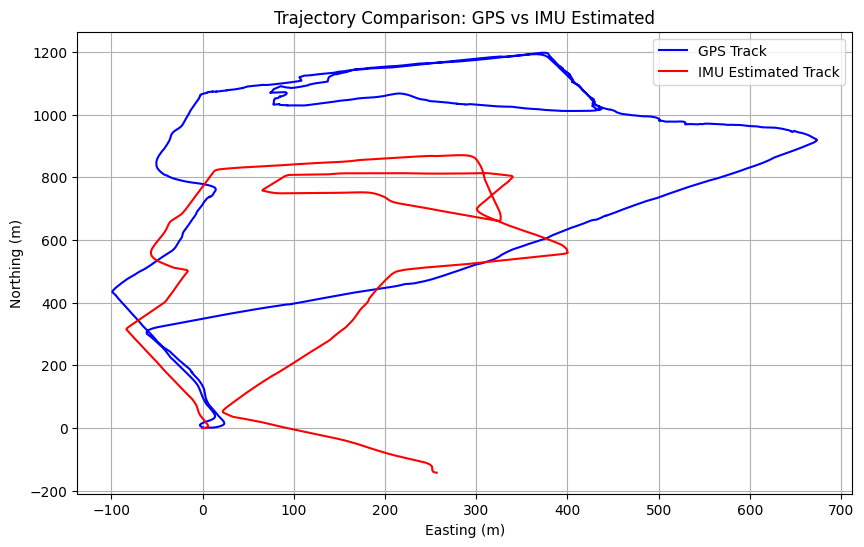

In [1028]:
# compl_filter = np.deg2rad(complementary_filter)
# compl_filter = wrap_to_pi(compl_filter)
# wrapped_yaw = wrap_to_pi(np.deg2rad(euler_yaw_deg))
v_east = initial_velocity * np.sin(np.deg2rad(compl_filter))
v_north = initial_velocity * np.cos(np.deg2rad(compl_filter))

dis_east = cumtrapz(v_east, t, initial=0)
dis_north = cumtrapz(v_north, t, initial=0)

utm_easting = gps_driving['utm_easting']
utm_northing = gps_driving['utm_northing']

utm_easting = utm_easting - utm_easting[0]
utm_northing = utm_northing - utm_northing[0]

gps_heading = -np.arctan2(utm_northing[70],utm_easting[70])
print(utm_easting[70])
print(utm_northing[70])
print(np.degrees(gps_heading))

#rotate the imu data by the angle
gps_heading = np.deg2rad(-137)
heading_east = dis_east  * np.cos(gps_heading) - dis_north * np.sin(gps_heading)
heading_north = dis_east * np.sin(gps_heading) + dis_north * np.cos(gps_heading)
plt.figure(figsize=(10, 6))
# plt.plot(scaled_lat, scaled_lon, label="GPS Track", color="blue")
plt.plot(utm_easting, utm_northing, label="GPS Track", color="blue")
# plt.plot(dis_east, dis_north, label="IMU Estimated Track", color="green")
plt.plot(heading_east, heading_north, label="IMU Estimated Track", color="red")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.legend()
plt.title("Trajectory Comparison: GPS vs IMU Estimated")
plt.grid()
plt.show()

In [1085]:
#find the index where the heading north is 350
heading_north = np.array(heading_north)
heading_east = np.array(heading_east)

index = np.where(heading_east == min(heading_east))

print(df_driving['time'][index[0]])

7070    177.552974
Name: time, dtype: float64
